In [55]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
import argparse
import os
import matplotlib.pyplot as plt
import time
import codecs
import csv

## Slecting random seed of Torch and Numpy respectively

In [56]:
manualSeed = 144

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)

## Check if we have a CUDA-capable device; if so, use it

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Will train on {}'.format(device))

Will train on cpu


## Load CIFAR-10 dataset

In [58]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
# testset = torchvision.datasets.CIFAR10('./data', train=False, download=False, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('==> Finish Preparing.')

==> Preparing data..
Files already downloaded and verified
==> Finish Preparing.


## Split training data

In [59]:
lab_train = [trainset[x][1] for x in range(len(trainset))]
# lab_test = [testset[y][1] for y in range(len(testset))]

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torch.utils.data.dataset import Subset

def generate_train_indices(n_splits, train_size, lab):
    s = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, test_size=None)
    return [i.tolist() for i, _ in s.split(lab, lab)]

train_indices = generate_train_indices(1, 1000, lab_train)
train_subset = Subset(trainset, train_indices[0])
print(Counter([train_subset[i][1] for i in range(len(train_subset))]))
print(len(train_subset))

Counter({0: 100, 3: 100, 8: 100, 6: 100, 1: 100, 4: 100, 9: 100, 5: 100, 2: 100, 7: 100})
1000


In [80]:
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=8)
# testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)

print(len(trainloader.dataset))

1000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [81]:
def show_img(x):
    if x.size(0) == 1:   
        new_img = torch.cat([x, x, x], dim=0)
        img = new_img.permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(img, cmap ='binary')
    if x.size(0) == 3:
        mean = torch.tensor([x for x in [0.4914, 0.4822, 0.4465]], dtype=torch.float32).view(3,1,1).to(device)
        std = torch.tensor([x for x in [0.247, 0.243, 0.261]], dtype=torch.float32).view(3,1,1).to(device)
        img = x*std+mean
        img = img.permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(img)

## Encoder

In [94]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.GELU(),
            # nn.MaxPool2d(2, 2),
            )
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            # nn.MaxPool2d(2, 2),
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            # nn.MaxPool2d(2, 2),
            )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            # nn.MaxPool2d(2, 2),
            )

    def forward(self, x):
        out = self.block0(x)
        out = self.block1(out)
        out = self.block2(out)
        representation = self.block3(out)
        
        return representation

In [95]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            )
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.GELU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(3),
            nn.GELU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            )

    def forward(self, repres):
        out = self.block0(repres)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        
        return out

## Loss function

In [96]:
class L2Dis(nn.Module):
    def __init__(self):
        super(L2Dis,self).__init__()

    def forward(self, label1, label2, target1, target2):
        N = target1.size(0)
        size = target1.size(2) * target1.size(3)
        loss1 = torch.sum((label1-target1)**2)/N/size
        loss2 = torch.sum((label2-target2)**2)/N/size
        loss = loss1 + loss2
        return loss

In [97]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)

In [98]:
class NetWork(nn.Module):
    def __init__(self):
        super(NetWork,self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss = L2Dis()
        
    def forward(self, x, y1, y2):
        repres = self.encoder(x)
        img1 = self.decoder(repres)
        img2 = (x * 2).detach() - img1
        loss = self.loss(img1, img2, y1.detach(), y2.detach())
        return loss, img1, img2

## Save checkpoint.

In [99]:
import csv
import os

def save(net, epoch):
    print('Saving..')
    state = {
        'net': net,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + '_' + str(epoch), _use_new_zipfile_serialization=False)

## Load model

In [100]:
if os.path.isdir('checkpoint'):
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7_181')
    
    net = checkpoint['net']
    net = net.to(device)
    
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
    print('==> Finished')
    
else:
    print('==> Building model..')
    start_epoch = 0
    net = NetWork()
    if torch.cuda.device_count()>1:
        print("Let's use", torch.cuda.device_count(), 'GPUs!')
        net = nn.DataParallel(net)
    net = net.to(device)
    net.apply(weights_init)
    print('==> Finished')

==> Building model..
==> Finished


In [101]:
# @torchsnooper.snoop()
def train(epoch):
    net.train()
    L2loss = 0

    Start = time.time()
    for batch_idx, (inputs, _) in enumerate(trainloader):
      inputs1 = inputs.to(device)

      index = torch.randperm(inputs1.size(0))
      inputs2 = inputs1[index, :]

      inputs = (inputs1 + inputs2) / 2

      optimizer.zero_grad()

      loss, img1, img2 = net(inputs, inputs1.detach(), inputs2.detach())

      loss.mean().backward()
      optimizer.step()
      
      L2loss += loss.mean().item()
      C_loss = L2loss / (batch_idx+1)


    End = time.time()
    T = End - Start
    H = T // 3600
    M = (T % 3600) // 60
    S = (T % 3600) % 60
    print('using time is: ', H, 'H', M, 'M', S, 'S' )
    
    print("C_loss: ", C_loss)
    imgSet = [inputs1[0], inputs2[0], inputs[0], img1[0], img2[0]]
    fig = plt.figure(figsize=(128,32))
    for idx in np.arange(5):
      ax = fig.add_subplot(1, 5, idx+1)
      show_img(imgSet[idx])
    plt.show()

In [102]:
def adjust_learning_Crate(optimizer, epoch, num, Clr, warmup=0):
    lr = Clr*0.5*(1+np.cos(np.pi*(epoch - warmup)/(num - warmup)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [103]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

Epoch: 0
classifier training lr: 0.1


using time is:  0.0 H 0.0 M 17.327810764312744 S
C_loss:  5.995293021202087


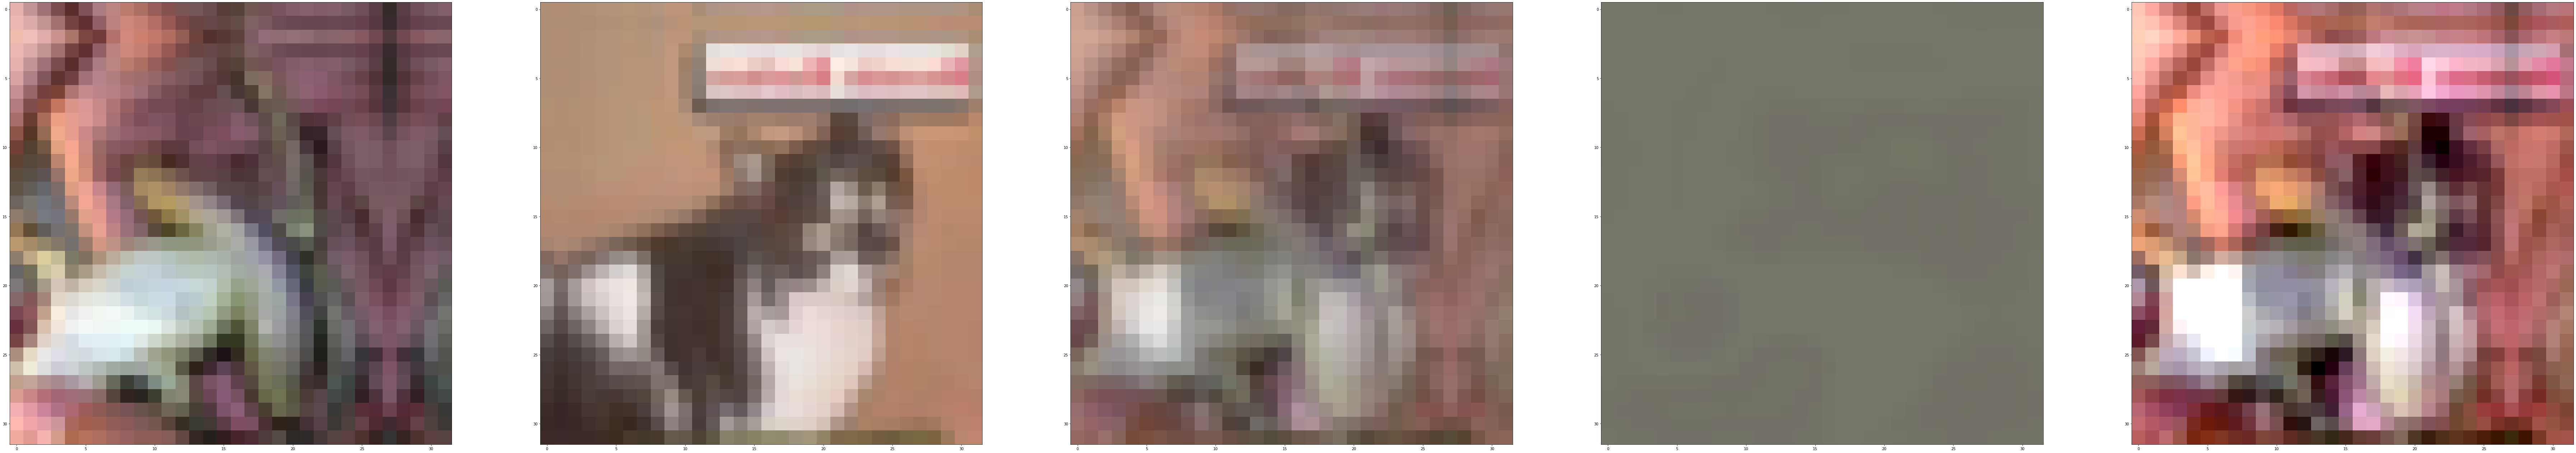

Epoch: 1
classifier training lr: 0.09997532801828658


using time is:  0.0 H 0.0 M 17.31169843673706 S
C_loss:  5.44914972782135


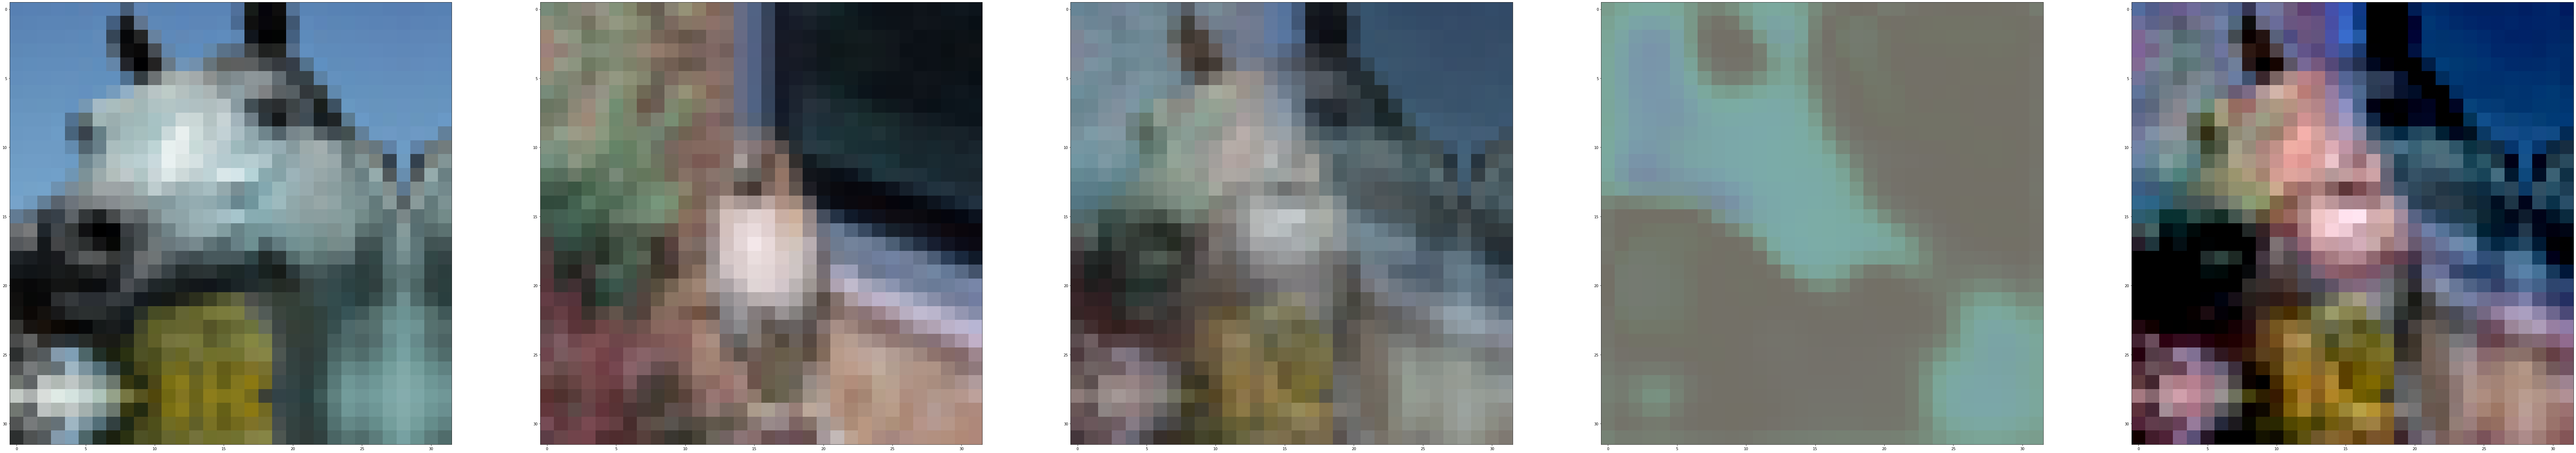

Epoch: 2
classifier training lr: 0.09990133642141358


using time is:  0.0 H 0.0 M 17.27150559425354 S
C_loss:  4.615460813045502


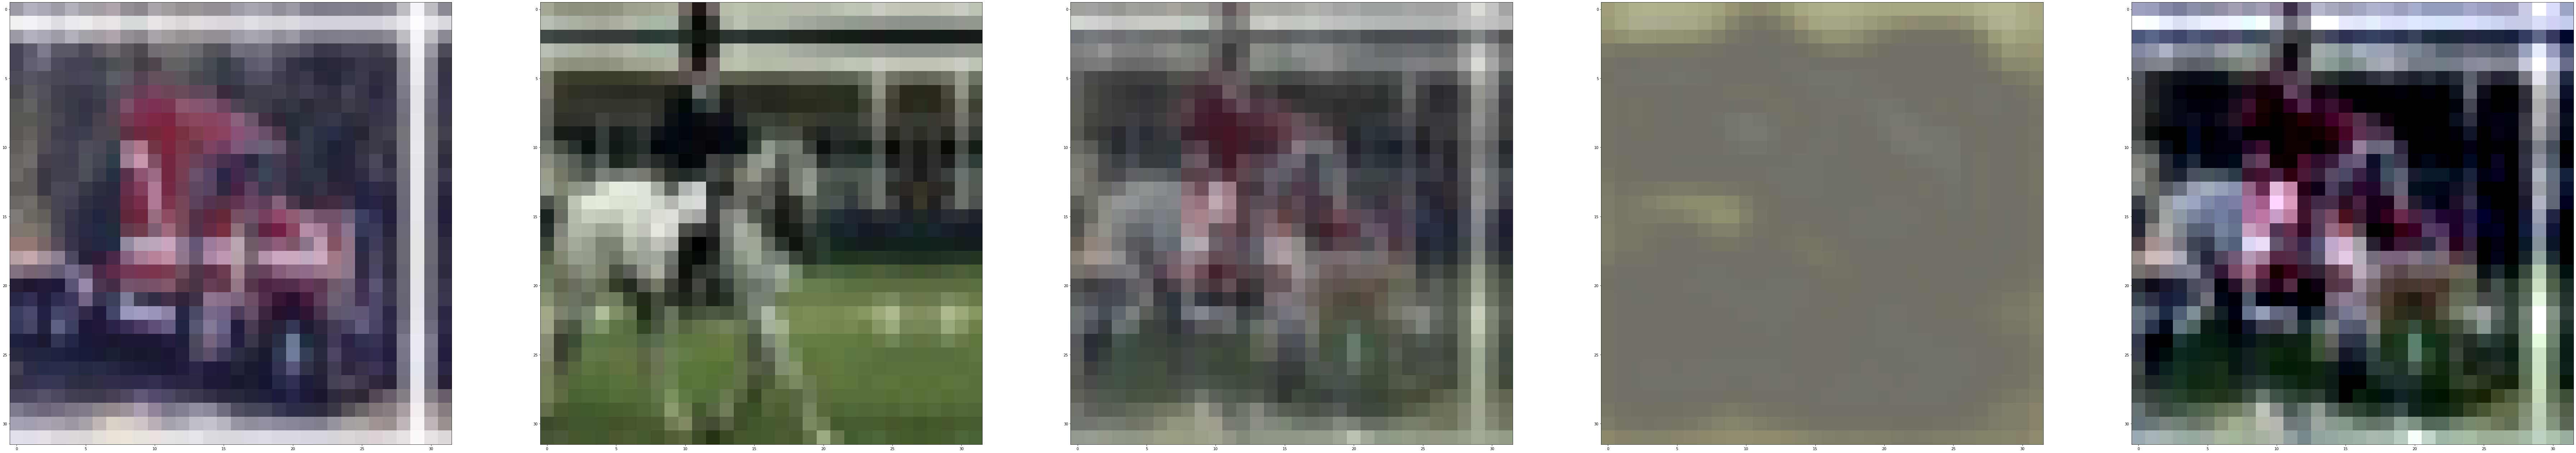

Epoch: 3
classifier training lr: 0.099778098230154


using time is:  0.0 H 0.0 M 17.359925985336304 S
C_loss:  4.39071449637413


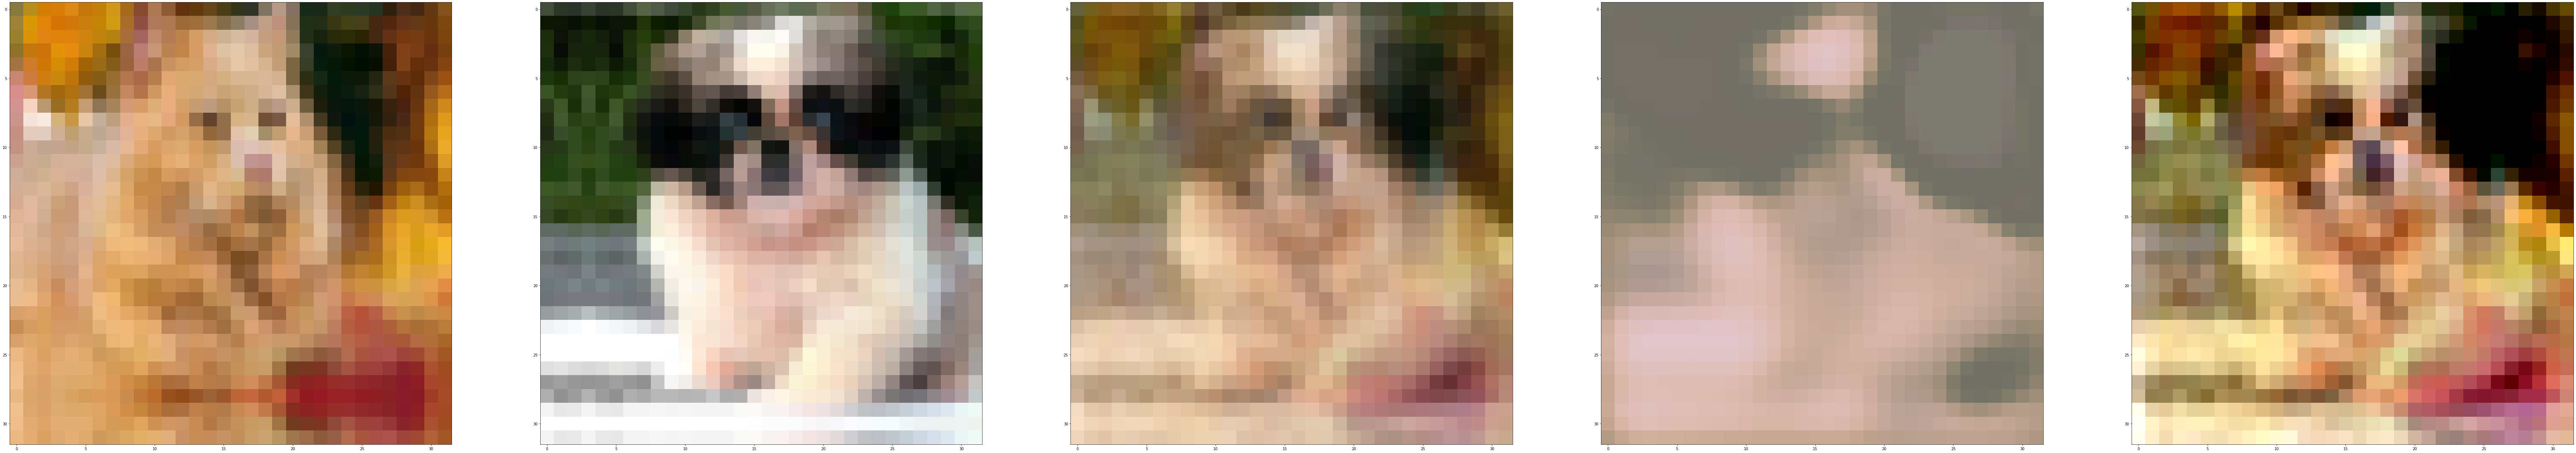

Epoch: 4
classifier training lr: 0.0996057350657239


using time is:  0.0 H 0.0 M 17.40557861328125 S
C_loss:  4.268494129180908


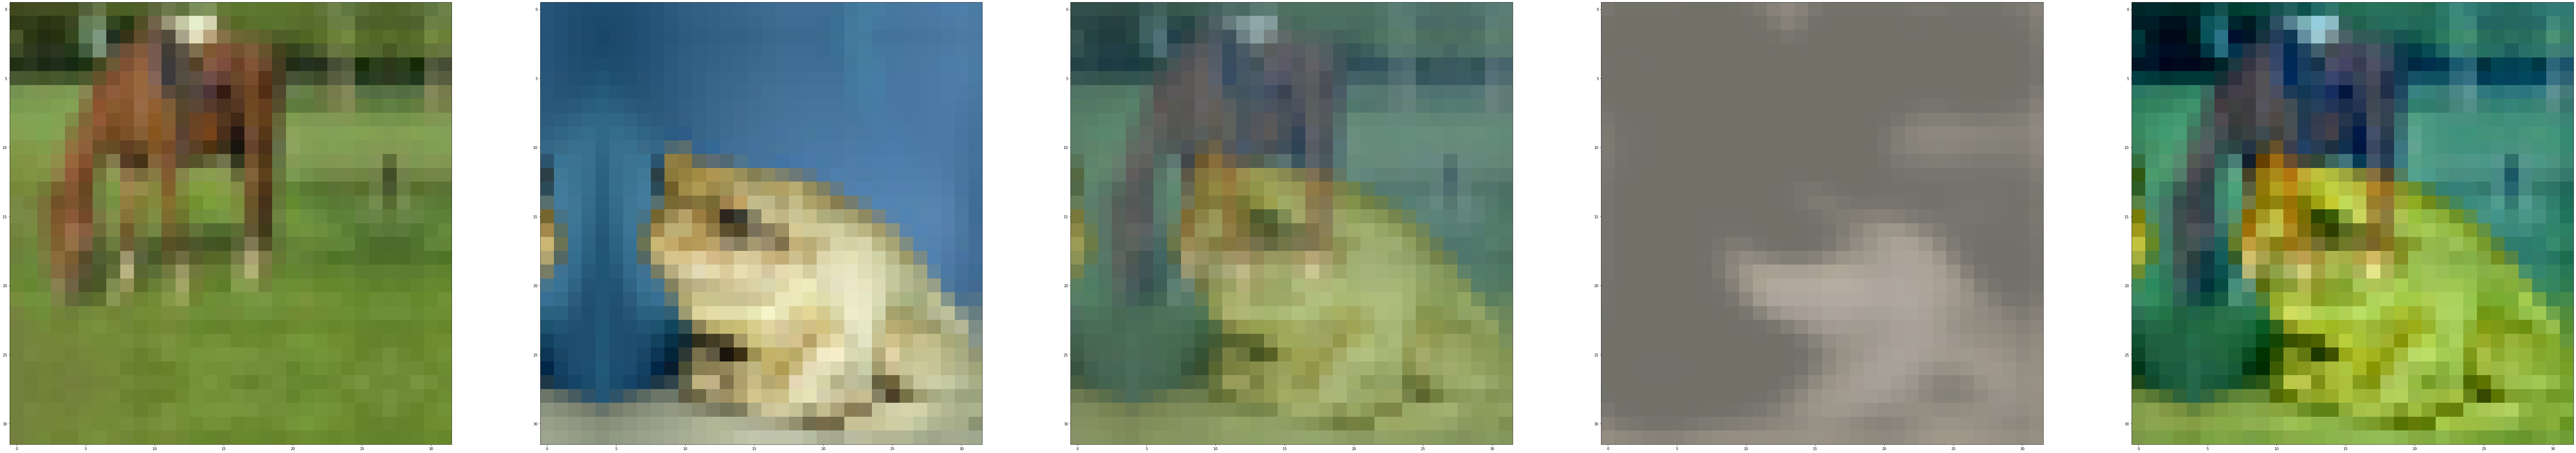

Epoch: 5
classifier training lr: 0.0993844170297569


using time is:  0.0 H 0.0 M 17.352564573287964 S
C_loss:  4.251581013202667


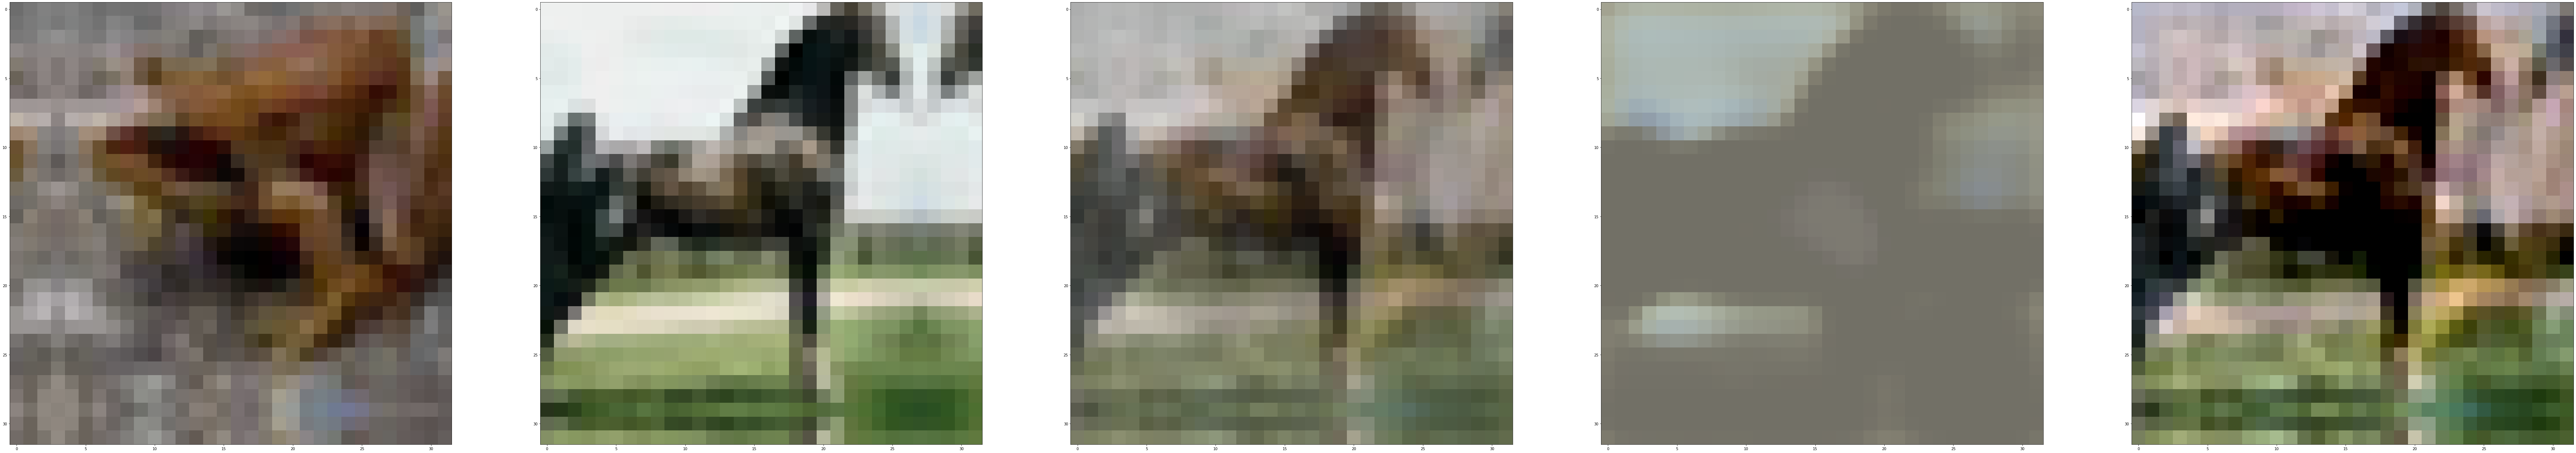

Epoch: 6
classifier training lr: 0.09911436253643445


using time is:  0.0 H 0.0 M 18.709169626235962 S
C_loss:  4.2266495525836945


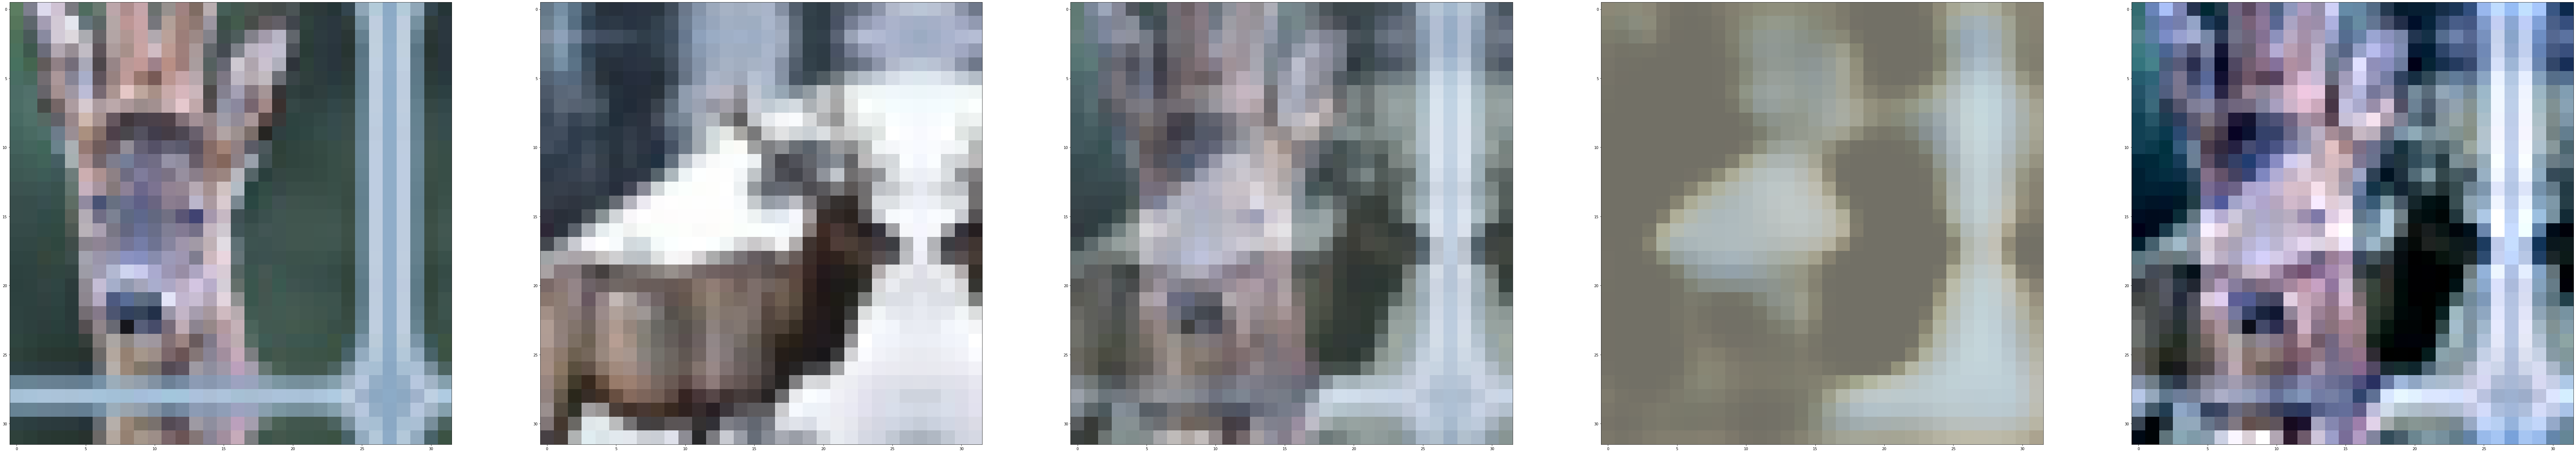

Epoch: 7
classifier training lr: 0.09879583809693737


using time is:  0.0 H 0.0 M 17.414132356643677 S
C_loss:  4.16560897231102


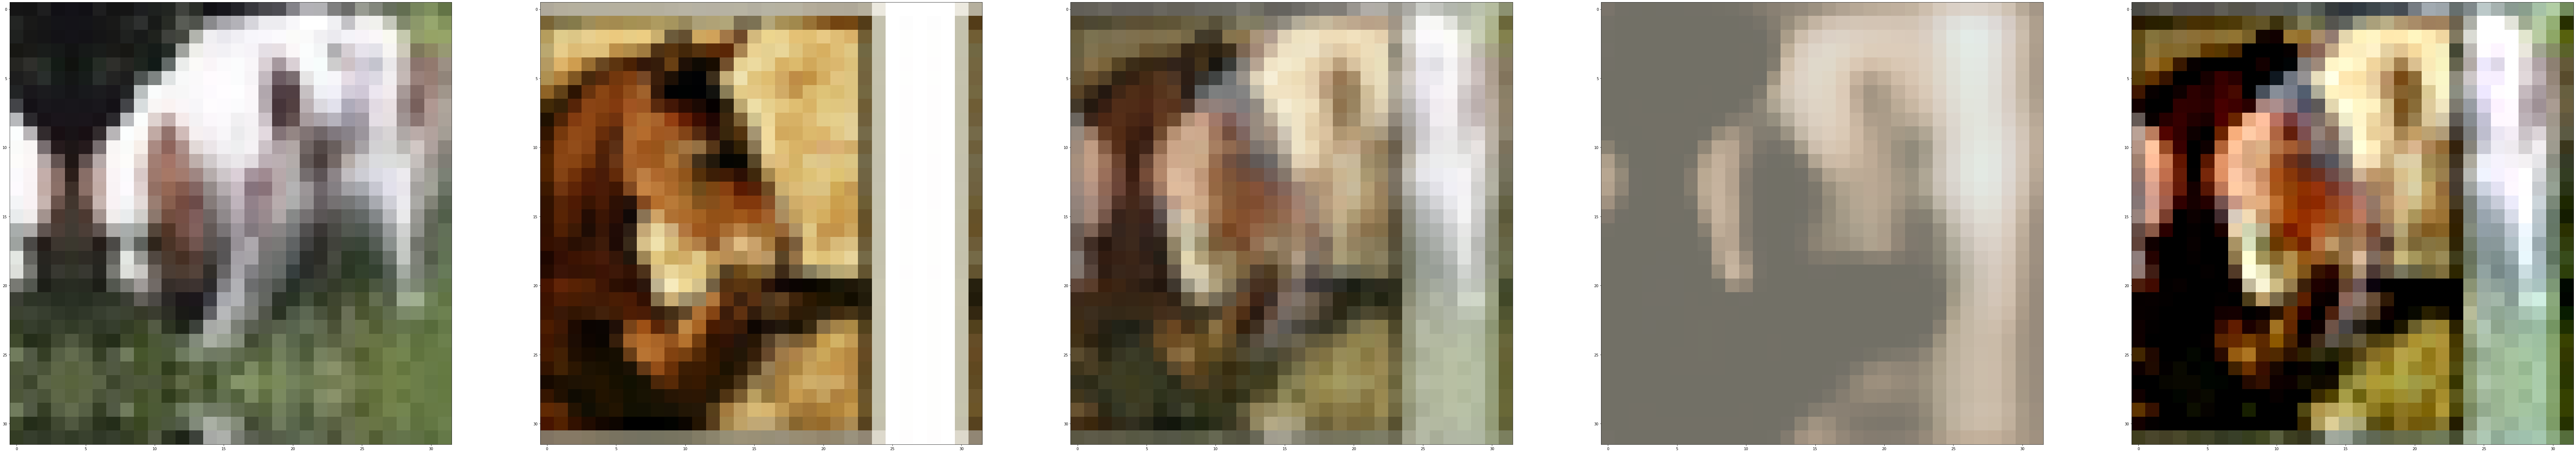

Epoch: 8
classifier training lr: 0.09842915805643156


using time is:  0.0 H 0.0 M 17.318728923797607 S
C_loss:  4.142907559871674


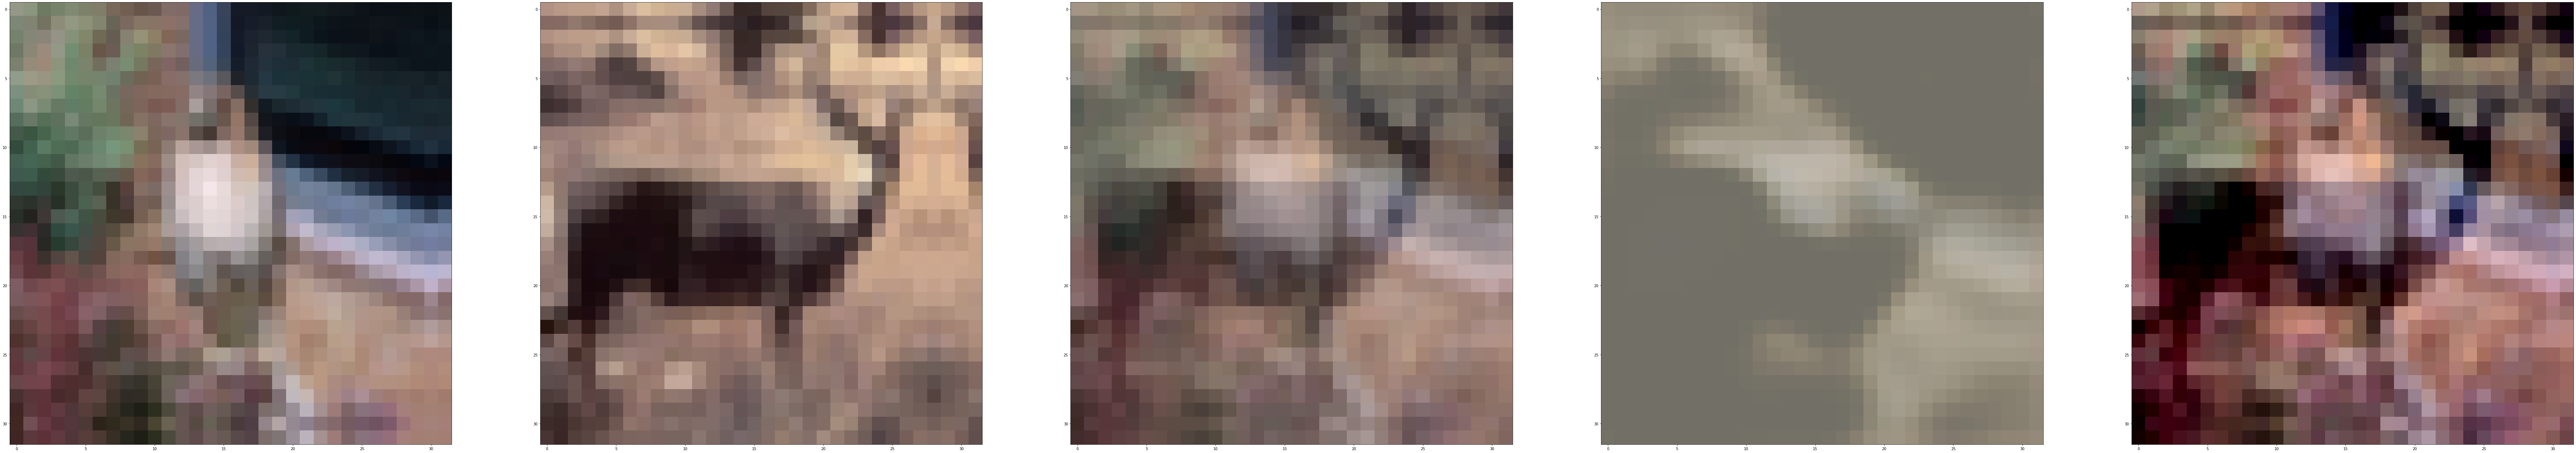

Epoch: 9
classifier training lr: 0.09801468428384716


using time is:  0.0 H 0.0 M 17.40889048576355 S
C_loss:  4.170044243335724


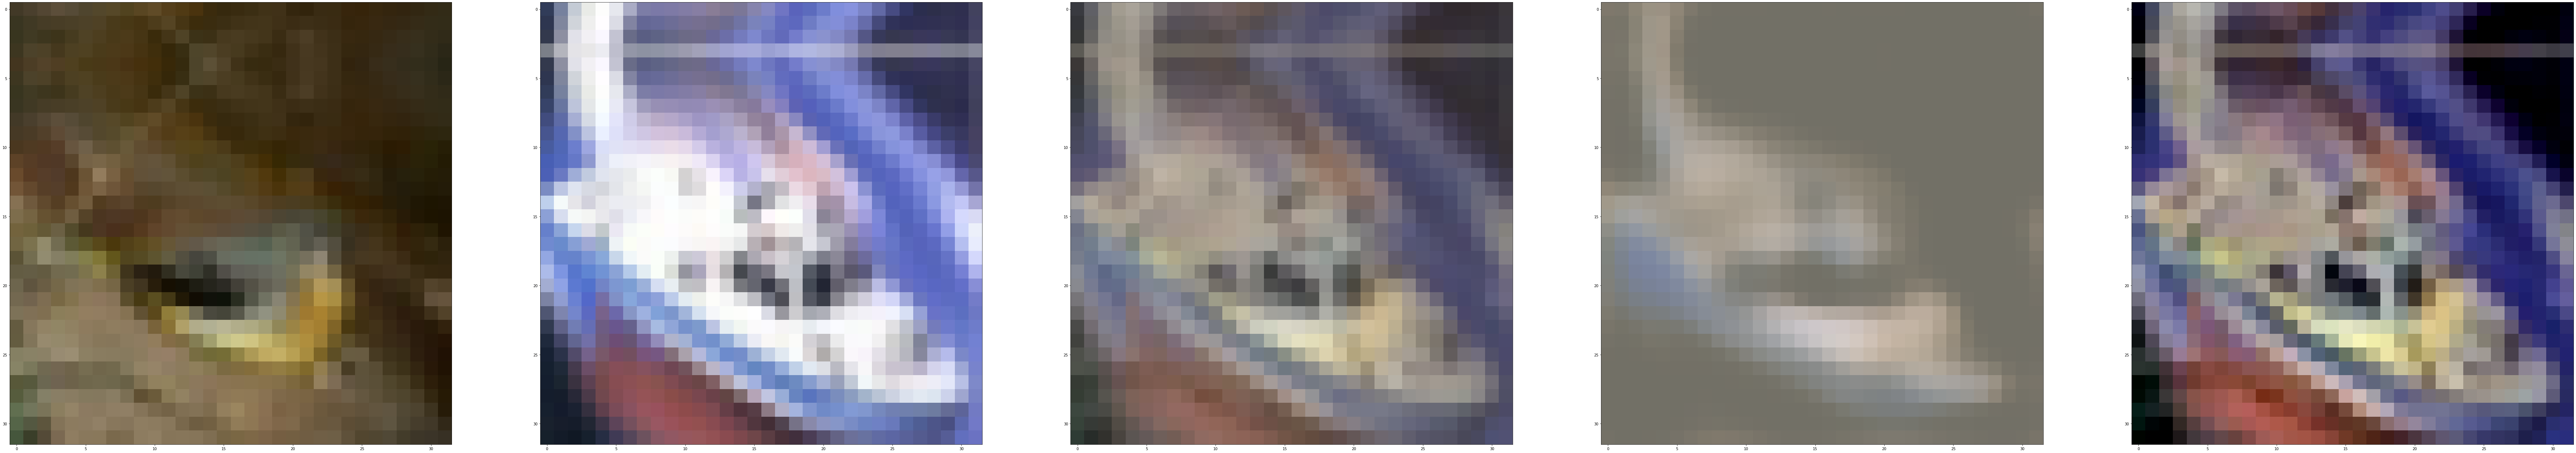

Epoch: 10
classifier training lr: 0.09755282581475769


using time is:  0.0 H 0.0 M 17.459828853607178 S
C_loss:  4.12944233417511


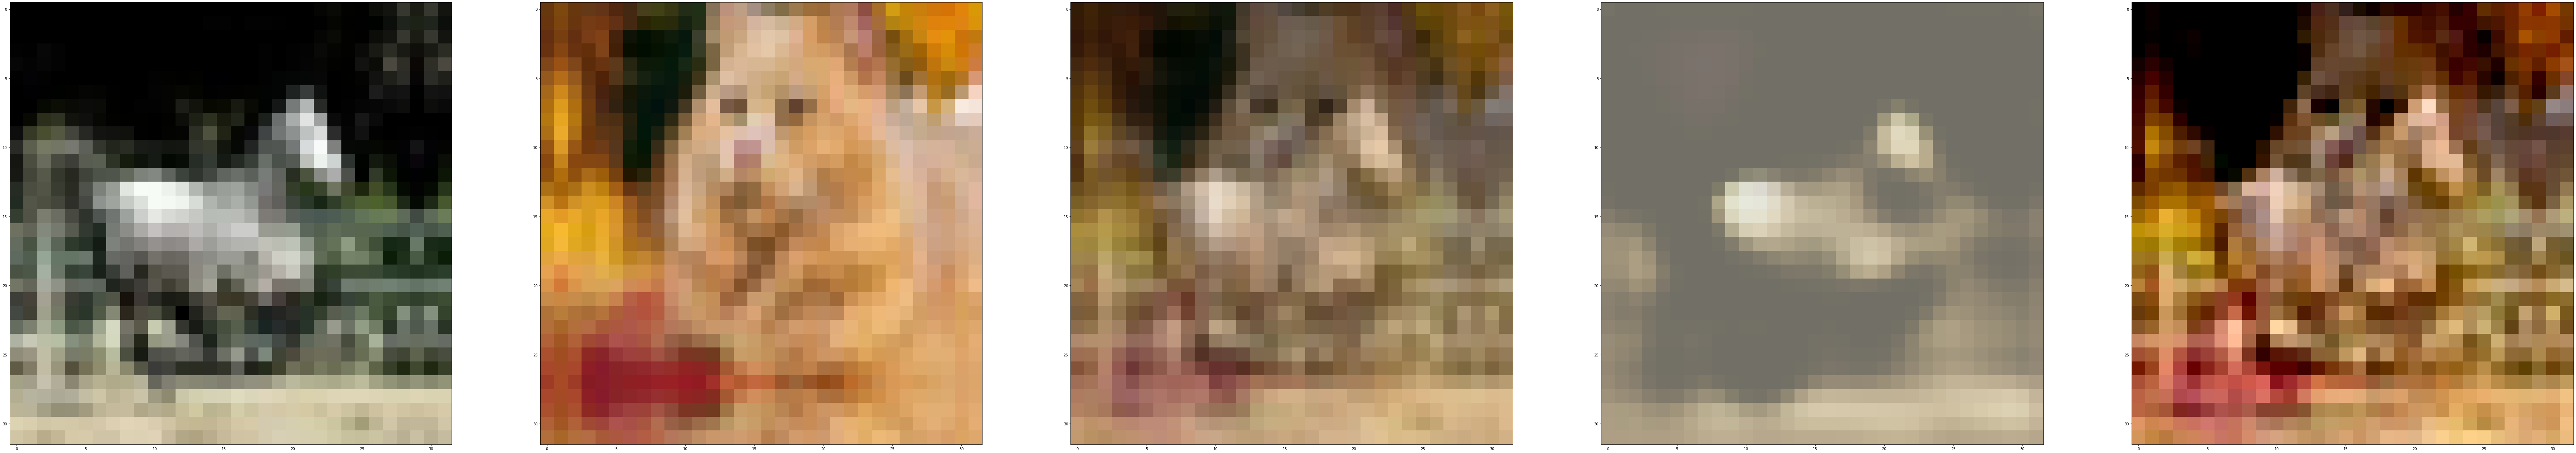

Epoch: 11
classifier training lr: 0.09704403844771128


using time is:  0.0 H 0.0 M 17.450855493545532 S
C_loss:  4.141337603330612


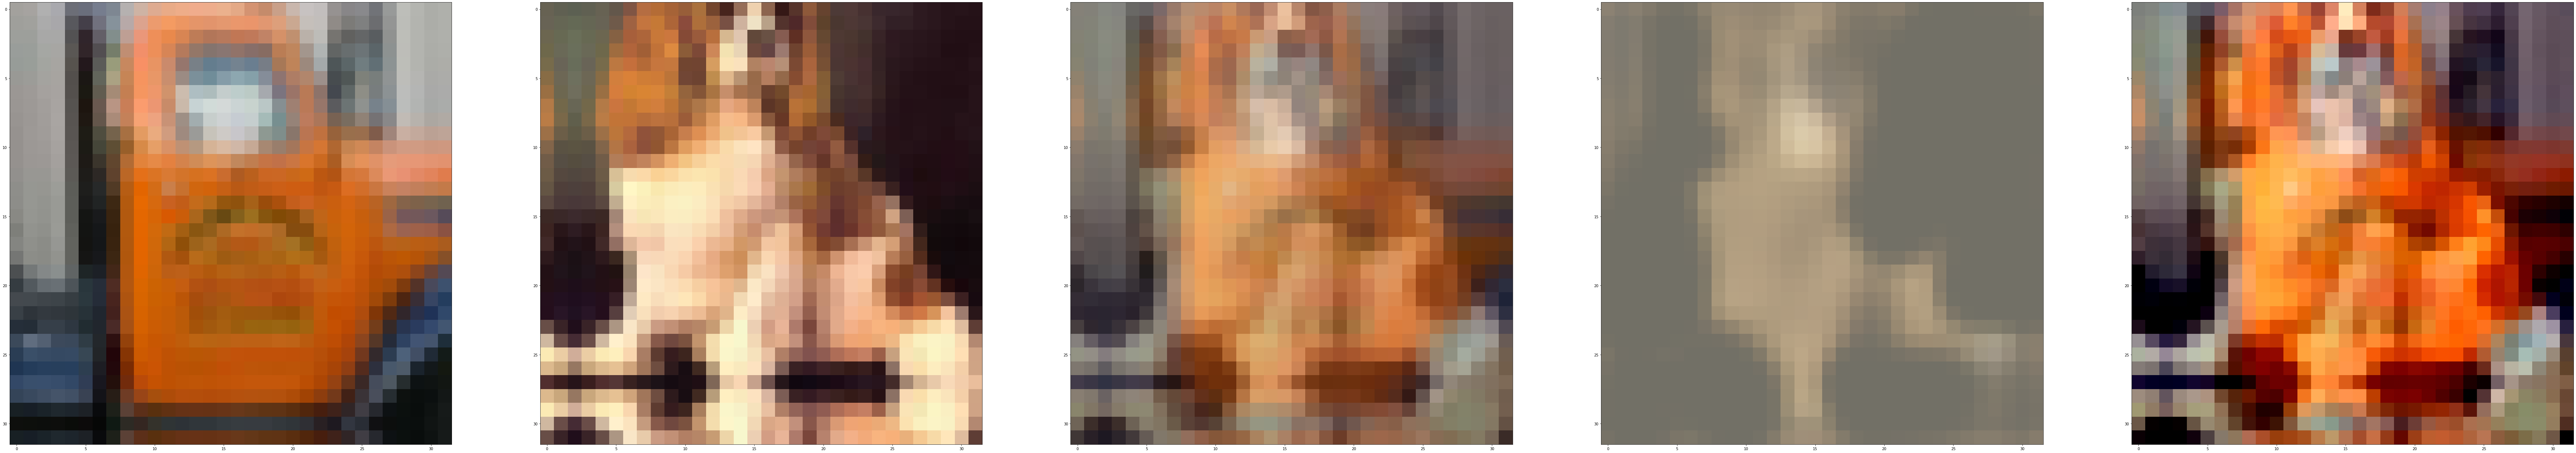

Epoch: 12
classifier training lr: 0.09648882429441258


using time is:  0.0 H 0.0 M 17.563648462295532 S
C_loss:  4.048247039318085


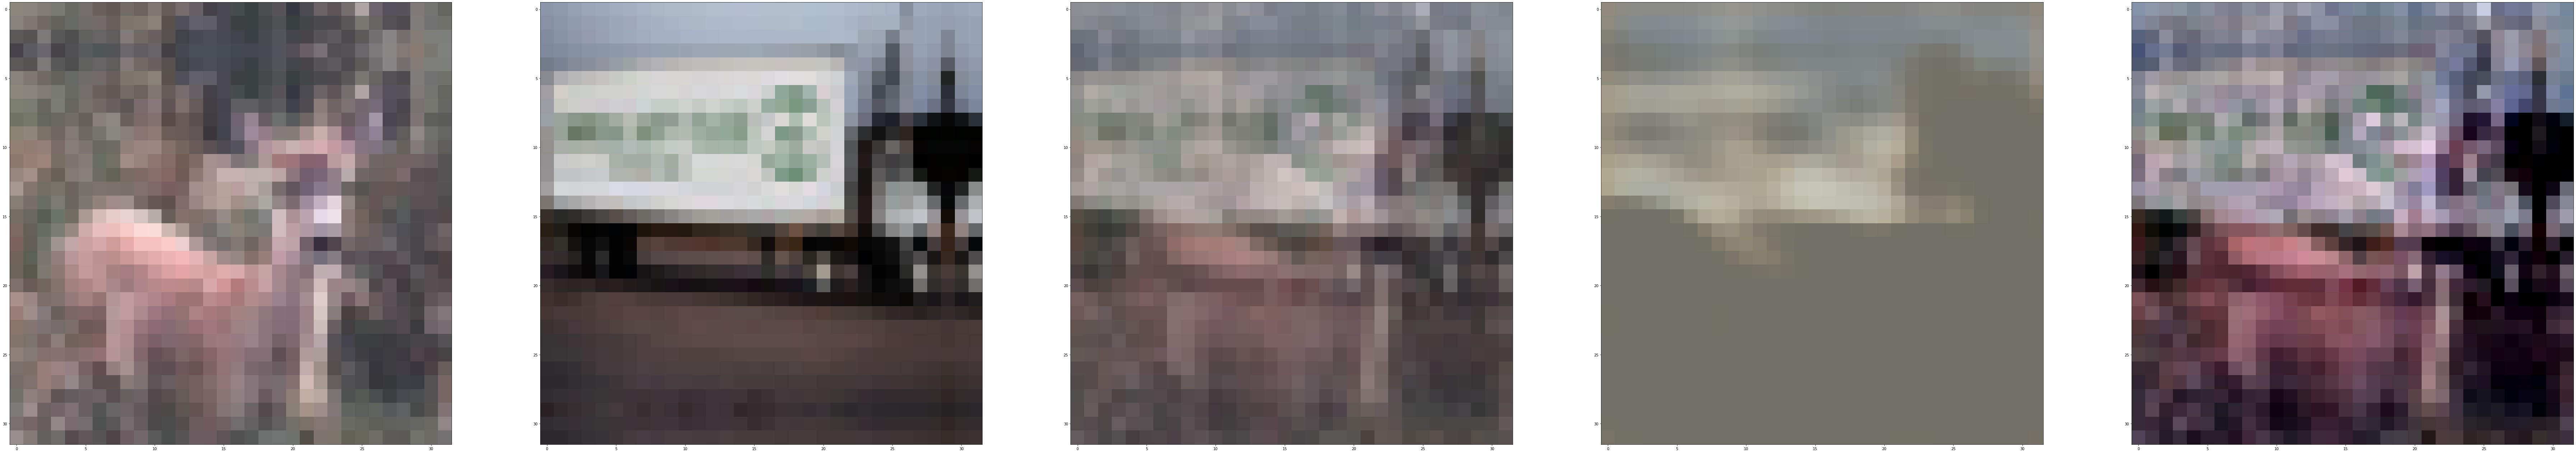

Epoch: 13
classifier training lr: 0.09588773128419906


using time is:  0.0 H 0.0 M 18.772874355316162 S
C_loss:  4.060227304697037


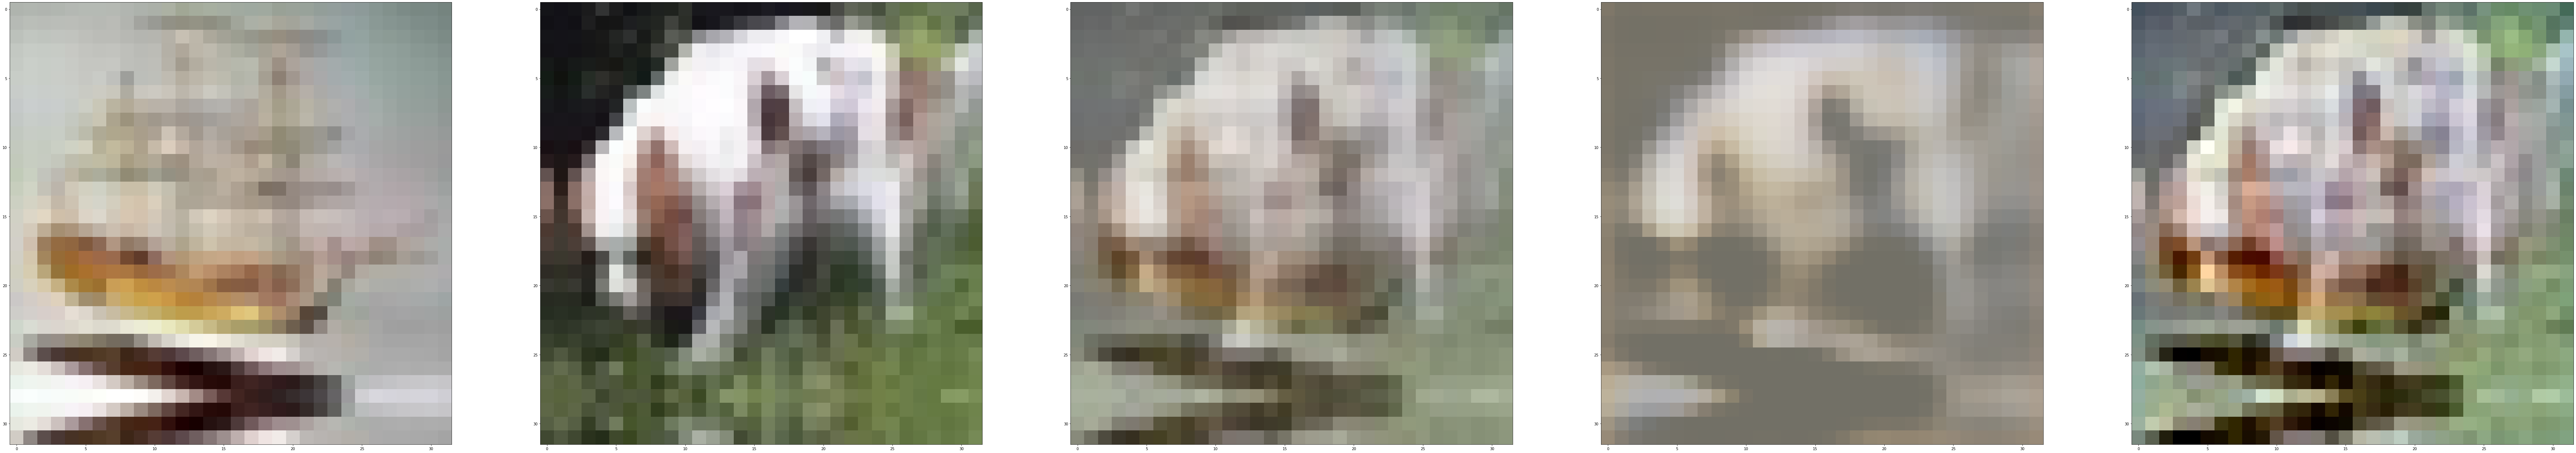

Epoch: 14
classifier training lr: 0.09524135262330098


using time is:  0.0 H 0.0 M 17.460819721221924 S
C_loss:  4.061128556728363


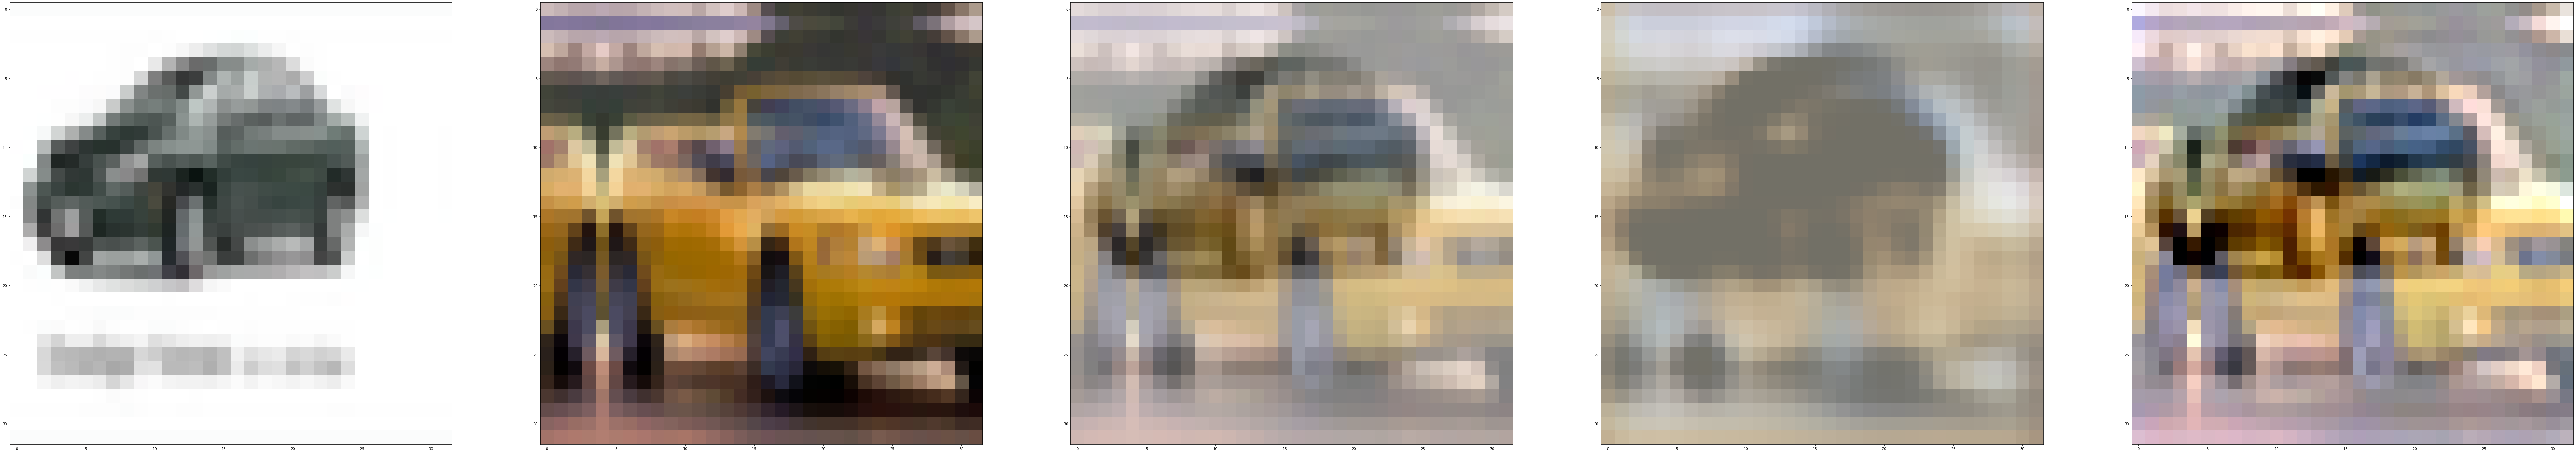

Epoch: 15
classifier training lr: 0.09455032620941839


using time is:  0.0 H 0.0 M 17.457854747772217 S
C_loss:  4.030829280614853


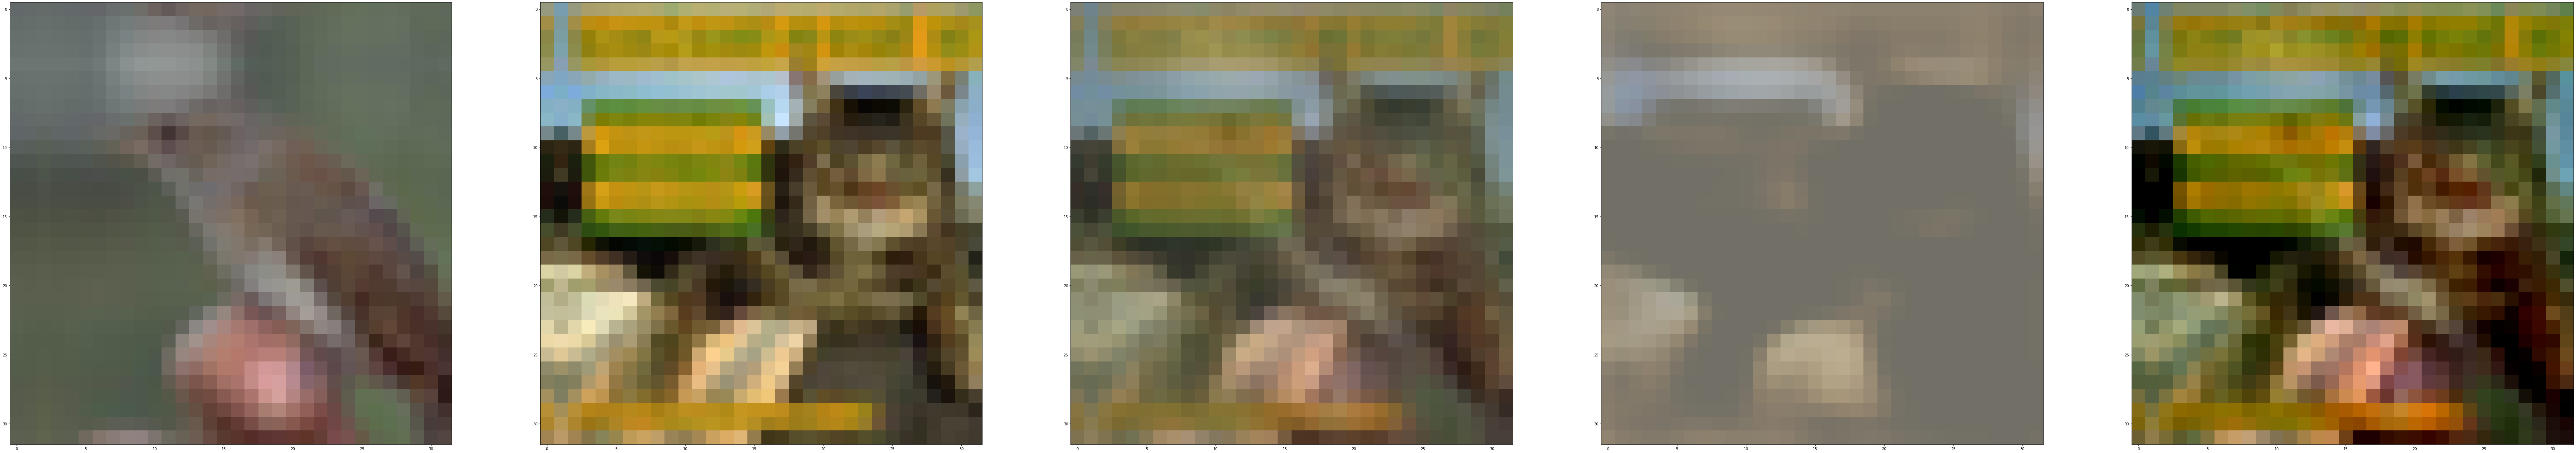

Epoch: 16
classifier training lr: 0.09381533400219318


using time is:  0.0 H 0.0 M 17.40193748474121 S
C_loss:  4.016698449850082


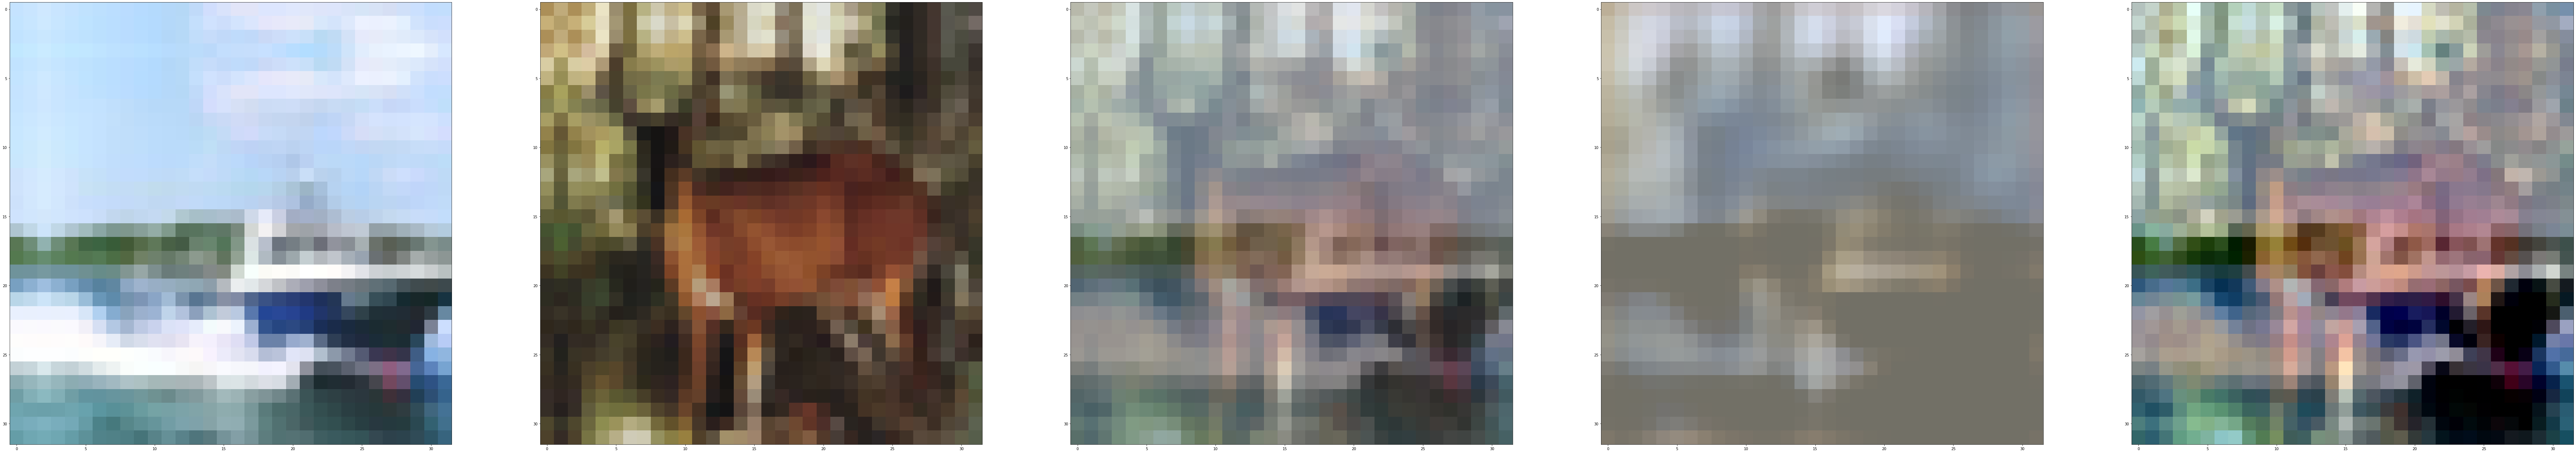

Epoch: 17
classifier training lr: 0.09303710135019719


using time is:  0.0 H 0.0 M 17.542051553726196 S
C_loss:  4.06151020526886


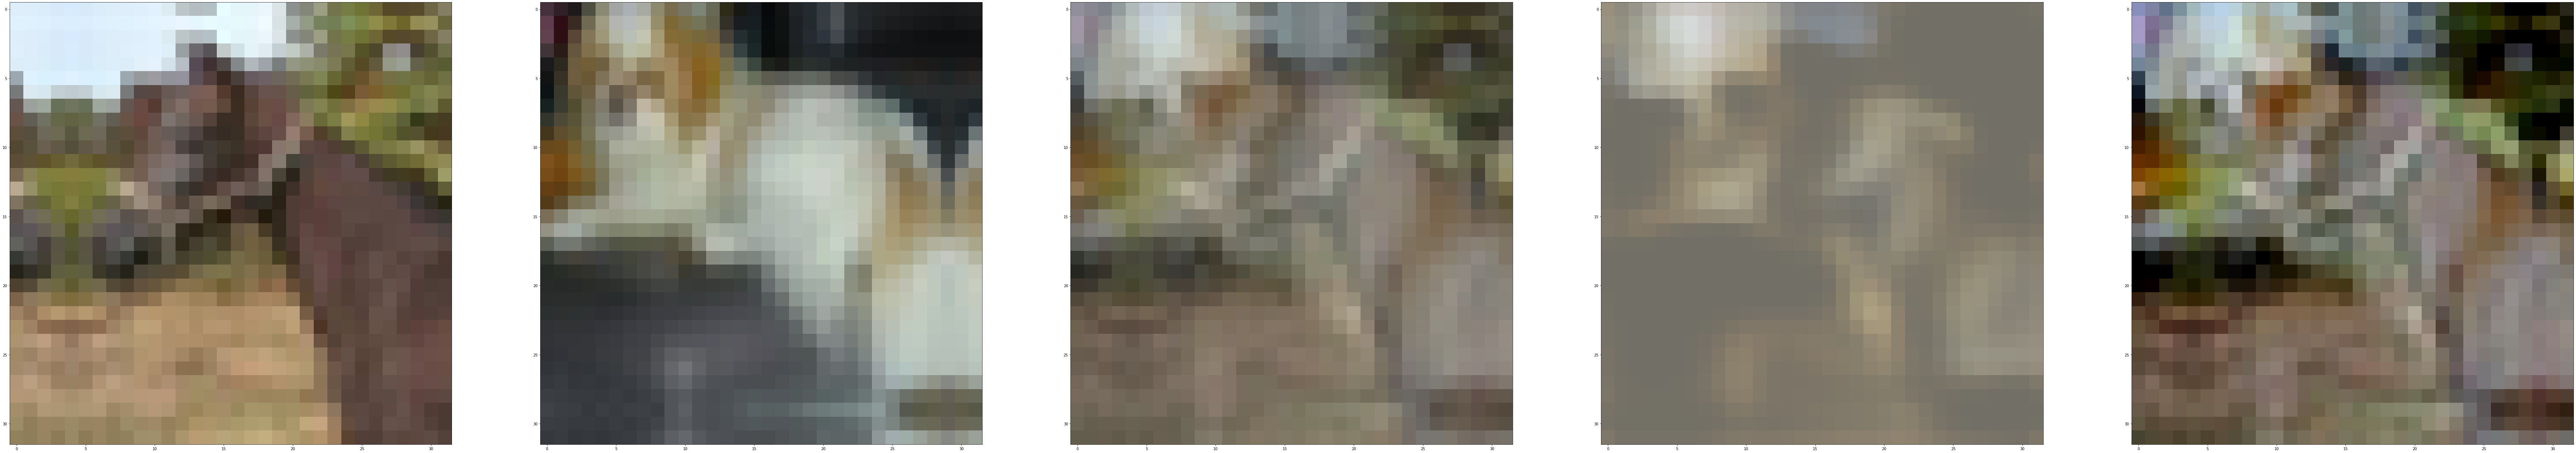

Epoch: 18
classifier training lr: 0.09221639627510075


KeyboardInterrupt: ignored

In [104]:
if __name__ == "__main__":
    n_epochs = 100
    Clr = 0.1

    epochStart = time.time()
    for epoch in range(start_epoch, n_epochs + 1):
      print('Epoch: %d' % epoch)

      adjust_learning_Crate(optimizer, epoch, n_epochs, Clr)
      clr = optimizer.param_groups[0]['lr']
      print('classifier training lr:', clr)
  
      train(epoch)
      
      # if epoch%10==9:
      #   save(net, epoch) 